## Introduction

This notebook is an implementation of the greedy poissoning attack on regression models as described in Kornaropoulos et. al - *The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures* (paper available on [Arxiv](https://arxiv.org/abs/2008.00297))

**TODO**: 
* Write proper documentation
* Speed-up implementation of Algorithm 1

In [1]:
import csv
import numpy as np
import pandas as pd
from itertools import groupby

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt  
import warnings, datetime
import scipy.stats as ss

## Greedy Poisoning Regression CDF

The following code implements Algorithm 1 (Greedy Poisoning Regression CDF) as described in the paper.

In [2]:
# Extracts non-occupied keys for a given sequence
def extract_non_occupied_keys(keyset):
    n = keyset.shape[0]
    
    lower_bound = int(keyset[0]-1)
    upper_bound = int(keyset[n-1]+1)
    
    non_occupied_keys = []
    for i in range(lower_bound, upper_bound + 1):
        if i not in keyset:
            non_occupied_keys.append(i)
        
    return non_occupied_keys

# Groups a list of keys into subsequences of consecutive keys 
def extract_seq(seq):
    return [
        [x for _, x in g]
        for k, g in groupby(
            enumerate(seq), 
            lambda i_x : i_x[0] - i_x[1]
        )
    ]   

# Extract the endpoints of each subsequence
def extract_endpoints(subsequences):
    endpoints = []
    for sequence in subsequences:
        if len(sequence) == 1:
            endpoints.append(sequence[0])
        else:
            endpoints.append(sequence[0])
            endpoints.append(sequence[len(sequence)-1])
            
    return endpoints

# Partition the non-occupied keys, i.e., keys not in K ∪ P, into subsequences such that each subsequence consists of consecutive non-occupied keys;
def partition_non_occupied_keys(K, P):
    keyset = np.append(K, list(P))
    keyset = np.sort(keyset)

    non_occupied_keys = extract_non_occupied_keys(keyset)
    
    subsequences = extract_seq(non_occupied_keys)
    endpoints = extract_endpoints(subsequences)
    return np.array(endpoints)

# Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence
def compute_rank_for_endpoints(endpoints, keyset):
    computed_rank_for_endpoint = []
    
    for endpoint in endpoints:
        keyset_extended = np.append(keyset, endpoint)
        rank = list(ss.rankdata(keyset_extended))
        # extract rank for the last element in the list (endpoint)
        computed_rank_for_endpoint.append(int(rank[len(rank)-1]))
    
    return computed_rank_for_endpoint
    

In [3]:
import operator
from statistics import mean

def obtain_poisoning_keys(p, keyset, rankset):
    # Total number of elements
    n = keyset.shape[0]

    # Number of posoning keys p
    P = p * n
    poisoning_keys = set()

    for j in range(int(P)):
        # Partition the non-occupied keys into subsequences such that each subsequence consists of consecutive non-occupied keys;
        # Extract the endpoints of each subsequence and sort them to construct the new sequence of endpoints S(i), where i <= 2(n + j);
        endpoints = partition_non_occupied_keys(keyset, poisoning_keys)

        # Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence T (i), where i <= 2(n + j) ;
        list_rank = compute_rank_for_endpoints(endpoints, keyset)

        # Compute the effect of choosing S(1) as a poisoning key and inserting it to K ∪ P with the appropriate rank adjustments. 
        # Specifically, evaluate the sequences each of which is the mean M for a different variable, e.g., K, R, KR. Compute MK (1), MK2 (1), MKR(1), and L(1) ;
        S = endpoints
        T = list_rank
        
        delta_S = {}
        M_K = {}
        M_K_square = {}
        M_R = {}
        M_R_square = {}
        M_KR = {}
        L = {}
        
        # Calculate M_K(1), M_R(1) etc.
        current_keyset = np.append(keyset, S[0])
        M_K[0] = np.mean(keyset)

        current_rankset = np.append(rankset, T[0])
        M_R[0] = np.mean(rankset)

        M_K_square[0] = np.mean(keyset**2)

        M_R_square[0] = np.mean(rankset**2)

        M_KR[0] = np.mean(keyset*rankset)

        nominator = (M_KR[0] - (M_K[0] * M_R[0]))**2
        denominator = M_K_square[0] - (M_K[0])**2
        L[0] = - (nominator / denominator) + M_R_square[0] - (M_R[0])**2

        for i in range(1, len(endpoints)-1):
            # Calculate M_K(i), M_R(i) etc.
            delta_S[i] = S[i+1] - S[i] 

            M_K[i] = M_K[i-1] + delta_S[i] / (n) 
            M_K_square[i] = M_K_square[i-1] + (( 2 * S[i] + delta_S[i]) * delta_S[i]) / (n + 1) 

            M_R[i] = (n + 2) / 2
            M_R_square[i] = ((n+2)*(2*n+3)) / 6
            M_KR[i] = M_KR[i-1] + ( T[i-1] * delta_S[i]) / (n + 1)

            nominator = (M_KR[i] - M_K[i]*M_R[i])**2
            denominator = M_K_square[i] - (M_K[i])**2
            L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2

        # get argmax of items in L
        optimal_key_index = max(L.items(), key=operator.itemgetter(1))[0]
        poisoning_keys.add(S[optimal_key_index])
    
    return poisoning_keys

## Linear regression with non-poissoned keys

In [4]:
df=pd.read_csv('data/random_500.csv', sep=',',header=None)

X = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])
regressor_legitimate = LinearRegression()
regressor_legitimate.fit(X, y) 

y_pred = regressor_legitimate.predict(X)
mse_legitimate = metrics.mean_squared_error(y, y_pred)

In [5]:
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  

Mean Squared Error: 14.705531571425096


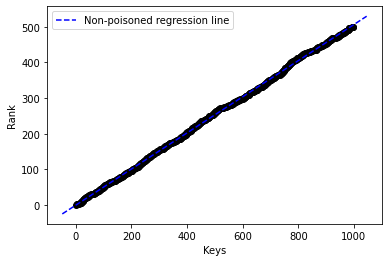

In [6]:
def abline(slope, intercept, color, label):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color, label = label)
    plt.legend()
    plt.xlabel('Keys')
    plt.ylabel('Rank')

# Plot outputs
plt.scatter(X, y,  color='black')
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
 
plt.show()

## Linear regression with poissoned keys

In [7]:
poisoning_keys = obtain_poisoning_keys(p = 0.2, keyset=X, rankset=y)

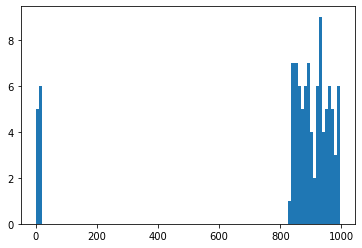

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def plot_distribution_of_poisoning_keys(poisoning_keys):
    # we observe that poissoning keys are densly populated together
    plt.hist(poisoning_keys, bins = 100, range=[0, df[0][len(df)-1]])
    plt.show()

plot_distribution_of_poisoning_keys(poisoning_keys)

In [9]:
X_poissoned = np.append(X, list(poisoning_keys))
y_poissoned = ss.rankdata(X_poissoned)

In [10]:
X_poissoned = X_poissoned.reshape(-1,1)
regressor_poissoned = LinearRegression()
regressor_poissoned.fit(X_poissoned, y_poissoned)  

y_poissoned_pred = regressor_poissoned.predict(X_poissoned)

In [11]:
print("------------------")
print('Mean Squared Error:', metrics.mean_squared_error(y_poissoned, y_poissoned_pred))  
mse_poissoned = metrics.mean_squared_error(y_poissoned, y_poissoned_pred)

------------------
Mean Squared Error: 300.3537350757655


In [12]:
ratio_loss =  mse_poissoned / mse_legitimate

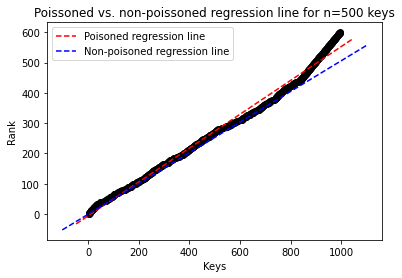

In [13]:
# Plot outputs
plt.scatter(X_poissoned, y_poissoned,  color='black')
abline(regressor_poissoned.coef_, regressor_poissoned.intercept_, color="red", label="Poisoned regression line")
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
label= "Poissoned vs. non-poissoned regression line for n="+ str(X.shape[0]) + " keys"
plt.title(label=label)
plt.show()

## Experiments with different key sizes / different poisoning percentages

In [14]:
import random

def generate_uniform_data(size):
    
    data = random.sample(range(2, size * 2), size)
    data.sort()
    return data

-------------------------
Dataset size:  500
Mean Squared Error: 7.845747708891319
Mean Squared Error: 8.467732440858795
Mean Squared Error: 11.215226613024686
Mean Squared Error: 14.661377720869043
Mean Squared Error: 21.13336447719464
Mean Squared Error: 28.2468308702524
Mean Squared Error: 37.08176092935949
Mean Squared Error: 50.63552820301346
Mean Squared Error: 63.4473907753315
Mean Squared Error: 82.32308846398377
Mean Squared Error: 99.50007423571904
Mean Squared Error: 123.66999547116096
Mean Squared Error: 133.47076607001554
Mean Squared Error: 154.84625666818457
Mean Squared Error: 183.20491606433845


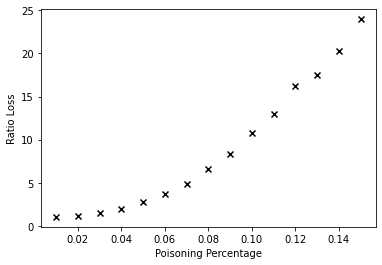

-------------------------
Dataset size:  1000
Mean Squared Error: 29.20950930243165
Mean Squared Error: 28.73936339676178
Mean Squared Error: 32.176791227817205
Mean Squared Error: 35.08883783354708
Mean Squared Error: 43.4970883239061
Mean Squared Error: 57.27114342477894
Mean Squared Error: 79.48961558384141
Mean Squared Error: 107.037448688015
Mean Squared Error: 150.24940791934952
Mean Squared Error: 200.01366051889022
Mean Squared Error: 246.29860679595322
Mean Squared Error: 321.75532496782773
Mean Squared Error: 400.6066224418165
Mean Squared Error: 489.25487135241497
Mean Squared Error: 575.3709363962691


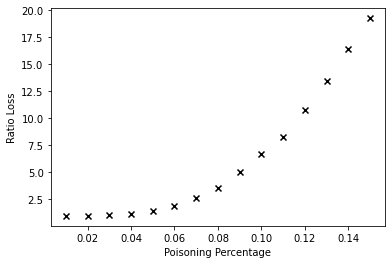

-------------------------
Dataset size:  2000
Mean Squared Error: 81.7259680092871
Mean Squared Error: 83.39374369438958
Mean Squared Error: 97.83046158865788
Mean Squared Error: 129.27163177440735
Mean Squared Error: 193.5721128499538
Mean Squared Error: 285.3018410924501
Mean Squared Error: 394.81214837080097
Mean Squared Error: 546.1966426604505
Mean Squared Error: 718.6174443889815
Mean Squared Error: 930.9965828677326
Mean Squared Error: 1176.0809444324789
Mean Squared Error: 1452.351946913503
Mean Squared Error: 1702.1694537844708
Mean Squared Error: 2053.641956018204
Mean Squared Error: 2413.6704405061255


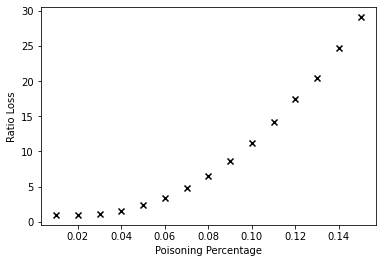

In [15]:
dataset_sizes = [500, 1000, 2000]

for dataset_size in dataset_sizes:
    
    print("-------------------------")
    print("Dataset size: ", dataset_size)
    X = generate_uniform_data(dataset_size)
    X = np.array(X).reshape(-1, 1)
    
    y = np.linspace(1, dataset_size, num=dataset_size)

    poisoning_percentages = np.linspace(0.01, 0.15, num= 15)

    ratio_losses = []
    
    regressor_legitimate = LinearRegression()
    regressor_legitimate.fit(X, y) 

    y_pred = regressor_legitimate.predict(X)
    mse_legitimate = metrics.mean_squared_error(y, y_pred)

    for percentage in poisoning_percentages:
        poisoning_keys = obtain_poisoning_keys(p = percentage, keyset = X, rankset = y)

        #plot_poisoning_keys(poisoning_keys)

        X_poissoned = np.append(X, list(poisoning_keys))
        y_poissoned = ss.rankdata(X_poissoned)

        X_poissoned = X_poissoned.reshape(-1,1)
        regressor_poissoned = LinearRegression()
        regressor_poissoned.fit(X_poissoned, y_poissoned)  

        y_poissoned_pred = regressor_poissoned.predict(X_poissoned)

        print('Mean Squared Error:', metrics.mean_squared_error(y_poissoned, y_poissoned_pred))  
        mse_poissoned = metrics.mean_squared_error(y_poissoned, y_poissoned_pred)
        ratio_loss =  mse_poissoned / mse_legitimate

        ratio_losses.append(ratio_loss)

    plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
    plt.xlabel('Poisoning Percentage')
    plt.ylabel('Ratio Loss')
    plt.show()